# <center> Deep Learning: Individual Assignment </center>
##### <center> Author: Mikolaj Hilgert </center>

In [1]:
# Install the required packages
! pip install torch numpy matplotlib pandas seaborn -q

In [2]:
# If you want to use the model for inference only, set this to True
# This will disable the data preview, training and validation code, and only run the inference code
ONLY_INFERENCE = False
# If you want to round the predicted Rings to the nearest integer during inference, set this to True
ROUND_PRED_TO_INTEGER = False

To skip to inference section, click [here](#inference) and `Run All`.

### Import 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed
SEED = 31415926
torch.manual_seed(SEED)
np.random.seed(SEED)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


### Data preview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3342 non-null   object 
 1   Length          3342 non-null   float64
 2   Diameter        3342 non-null   float64
 3   Height          3342 non-null   float64
 4   Whole_weight    3342 non-null   float64
 5   Shucked_weight  3342 non-null   float64
 6   Viscera_weight  3342 non-null   float64
 7   Shell_weight    3342 non-null   float64
 8   Rings           3342 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 235.1+ KB
None

Pairplot of 'train.csv'


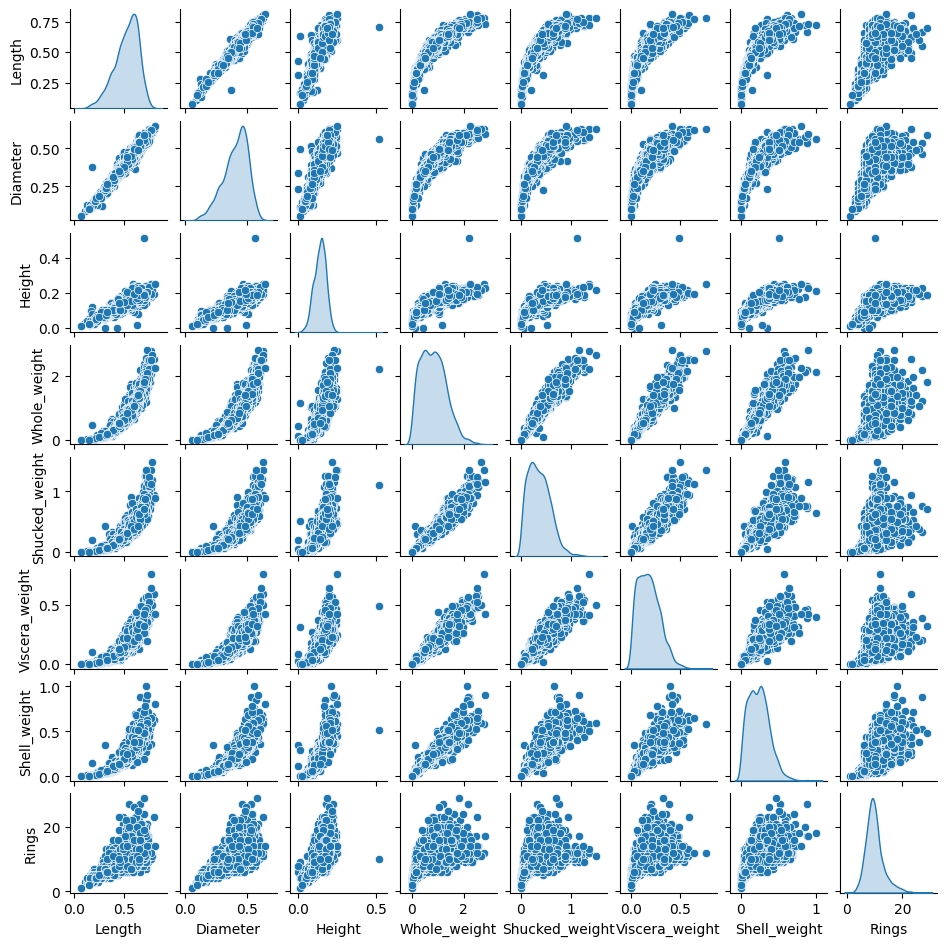

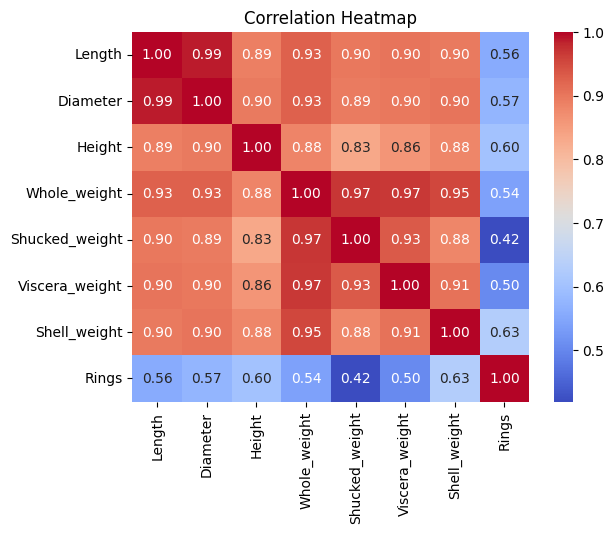

In [4]:
if not ONLY_INFERENCE:
    # Preview data
    df = pd.read_csv("data/train.csv")
    print(df.info())
    
    # Pairplot
    print("\nPairplot of 'train.csv'")
    sns.pairplot(df, diag_kind="kde", height=1.2)
    plt.show()

    # Correlation heatmap
    sns.heatmap(df.drop(columns=["Sex"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Heatmap")
    plt.show()

### Dataset Definition

In [5]:
class MyDataset(Dataset):  
    def __init__(self, csv_file, train=True):
        self.train = train
        
        # Load data from CSV
        self.data = pd.read_csv(csv_file)
        
        # Drop the target feature
        features = self.data.drop(columns=["Rings"]) if train else self.data

        # OHE of Sex (Categorical) feature 
        sex_mapping = {"M": 0, "F": 1, "I": 2}
        sex_labels = features["Sex"].map(sex_mapping).values
        categorical_features = torch.nn.functional.one_hot(torch.tensor(sex_labels), num_classes=len(sex_mapping))

        # Select and standardize the numerical features
        numerical_features = torch.tensor(features.select_dtypes(include=["float"]).values, dtype=torch.float)
        numerical_features = (numerical_features - numerical_features.mean(dim=0, keepdim=True)) / numerical_features.std(dim=0, keepdim=True)
        
        # Concatenate numerical and categorical features
        self.features = torch.cat((numerical_features, categorical_features), dim=1)

        # Use labels during training
        if self.train:
            self.labels = torch.tensor(self.data["Rings"].values, dtype=torch.float).unsqueeze(1)
        else:
            self.labels = None

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx): 
        if self.train:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

In [6]:
# Load the training dataset
train_dataset = MyDataset("data/train.csv", train=True)
test_dataset = MyDataset("data/test.csv", train=False)

# Split the training data into training and validation sets (80/20 split)
train_data, val_data = random_split(train_dataset, [0.8, 0.2])

# Create DataLoaders for mini-batch training
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

### MLP Definition

**Baseline Model**
- Architecture: Two hidden layers (64 → 32 neurons) as this is a smaller dataset. lower and larger counts were tested, but gave worse and similar performance.
- Activation: `ReLU` for stable gradients and efficient learning.
- Design Choice: No additional layers like BatchNorm, keeping the model straightforward.

**Advanced Model**
- Architecture & Activation: Same as baseline.
- Normalization: `BatchNorm1d` noralization activations, reducing internal covariance shift and stabilizing training, particularly useful when features vary widely in scale.
- Regularization: `L1 regularization` addresses the high feature correlation by pushing redundant weights to zero. I considered dropout regularization but chose Lasso given it resulted in a better performance.

In [7]:
class BaselineMLP(nn.Module):
    def __init__(self, input_dim=10):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),  
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.fc(x)

class MyMLP(nn.Module):
    def __init__(self, input_dim=10):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),  
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.fc(x)

# Instantiate the model
baseline = BaselineMLP()
model = MyMLP()
print("Baseline Model: \n", baseline)
print("\nAdvanced Model: \n", model)

Baseline Model: 
 BaselineMLP(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

Advanced Model: 
 MyMLP(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


### Model Training

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, patience, lambda_reg=None):
    # L1 regularization as sub function
    def l1_regularization(model, lambda_reg):
        l1_penalty = sum(param.abs().sum() for param in model.parameters())
        return lambda_reg * l1_penalty
    
    if ONLY_INFERENCE:
        return None, None
    
    model.to(device)
    best_val_loss = float("inf")
    best_state = None
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs+1):
        # Training
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            if lambda_reg:
                loss += l1_regularization(model, lambda_reg)
            loss.backward()
            optimizer.step()
            # Given we are using MSE loss, we need to multiply by the batch size to get the total loss 
            running_loss += loss.item() * features.size(0) 
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                # Again compute batch loss
                val_loss += loss.item() * features.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch}/{num_epochs}, Train MSE Loss: {epoch_train_loss:.4f}, Val MSE Loss: {epoch_val_loss:.4f}, Val RMSE Loss: {np.sqrt(epoch_val_loss):.4f}")
        
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            # We save the model state_dict to not constantly overwrite
            best_state = (epoch, best_val_loss, model.state_dict())
        else:
            if epoch - best_state[0] >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_state:
        # Save the best model state (weights)
        print(f"Best performing epoch: {best_state[0]}, Best Val MSE Loss: {best_state[1]:.4f}, Val RMSE Loss: {np.sqrt(best_state[1]):.4f}")
        torch.save(best_state[2], "best_model.pt")

    return train_losses, val_losses

In [9]:
# loss curve plot 
def plot_loss_curves(train_losses, val_losses, model_name=""):
    if ONLY_INFERENCE:
        return
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Train, Validation Loss Curve: " + model_name)
    plt.legend()
    plt.grid()
    plt.show()

Further choices that have been made regarding the optimizer, criterion and epoch count are outlined below:

`Adam (lr=1e-2)`: Adaptive learning rates help handle uneven feature usage (e.g., some categories or measurements might appear less).

`MSE Loss`: Standard for regression tasks. Predicting “rings” is a continuous target, so MSE directly measures squared deviation from the actual age. We can also get the square root of that value to get average error which is a natural and interpretable way to evaluate the performance.

`100 epochs`: Sufficient to allow convergence for this small dataset, as verified by the small deviations after ∼20 epochs in the loss graph.

`Early Stoppage`: Early stoppage with a patience of `25 epochs` is added, meaning if that the validation loss has not improved in after 25 epochs, we exit early.

In [10]:
# Set up training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
optimizer_baseline = optim.Adam(baseline.parameters(), lr=1e-2)
epochs = 100
patience = 25

Epoch 1/100, Train MSE Loss: 16.1378, Val MSE Loss: 4.3825, Val RMSE Loss: 2.0934
Epoch 2/100, Train MSE Loss: 5.1762, Val MSE Loss: 4.4856, Val RMSE Loss: 2.1179
Epoch 3/100, Train MSE Loss: 5.2604, Val MSE Loss: 4.4260, Val RMSE Loss: 2.1038
Epoch 4/100, Train MSE Loss: 4.9091, Val MSE Loss: 5.2546, Val RMSE Loss: 2.2923
Epoch 5/100, Train MSE Loss: 5.0873, Val MSE Loss: 4.3738, Val RMSE Loss: 2.0914
Epoch 6/100, Train MSE Loss: 4.7731, Val MSE Loss: 4.5810, Val RMSE Loss: 2.1403
Epoch 7/100, Train MSE Loss: 4.8453, Val MSE Loss: 4.1645, Val RMSE Loss: 2.0407
Epoch 8/100, Train MSE Loss: 4.7954, Val MSE Loss: 4.3715, Val RMSE Loss: 2.0908
Epoch 9/100, Train MSE Loss: 4.9415, Val MSE Loss: 4.6614, Val RMSE Loss: 2.1590
Epoch 10/100, Train MSE Loss: 4.6999, Val MSE Loss: 4.3103, Val RMSE Loss: 2.0761
Epoch 11/100, Train MSE Loss: 4.6944, Val MSE Loss: 4.1891, Val RMSE Loss: 2.0467
Epoch 12/100, Train MSE Loss: 4.5738, Val MSE Loss: 4.3910, Val RMSE Loss: 2.0955
Epoch 13/100, Train MSE 

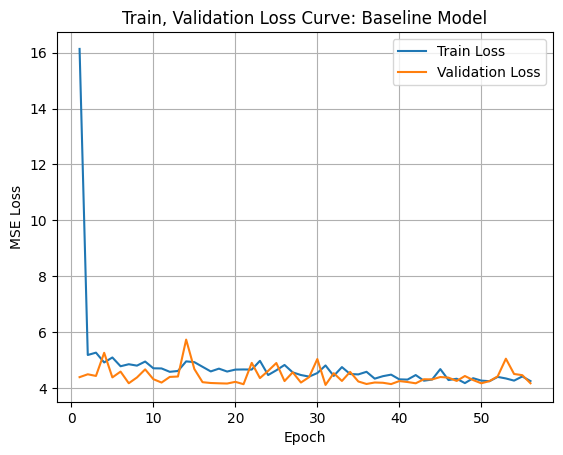

In [11]:
# Train the baseline model
baseline_train_losses, baseline_val_losses = train_model(baseline, criterion, optimizer_baseline, train_loader, val_loader, epochs, device, patience)
plot_loss_curves(baseline_train_losses, baseline_val_losses, "Baseline Model")

The model predicts the age of abalone with an average error of about 2 rings.

While the validation MSE and RMSE indicate that the model performs reasonably well, there is noticeable variability in the loss, suggesting some fluctuations in learning stability.


Epoch 1/100, Train MSE Loss: 28.4186, Val MSE Loss: 4.7959, Val RMSE Loss: 2.1899
Epoch 2/100, Train MSE Loss: 5.9862, Val MSE Loss: 4.5567, Val RMSE Loss: 2.1346
Epoch 3/100, Train MSE Loss: 5.8771, Val MSE Loss: 5.6611, Val RMSE Loss: 2.3793
Epoch 4/100, Train MSE Loss: 5.8961, Val MSE Loss: 5.2968, Val RMSE Loss: 2.3015
Epoch 5/100, Train MSE Loss: 5.7304, Val MSE Loss: 4.3726, Val RMSE Loss: 2.0911
Epoch 6/100, Train MSE Loss: 5.3993, Val MSE Loss: 4.7095, Val RMSE Loss: 2.1701
Epoch 7/100, Train MSE Loss: 5.6234, Val MSE Loss: 4.5325, Val RMSE Loss: 2.1290
Epoch 8/100, Train MSE Loss: 5.5602, Val MSE Loss: 4.2015, Val RMSE Loss: 2.0498
Epoch 9/100, Train MSE Loss: 5.2982, Val MSE Loss: 4.2858, Val RMSE Loss: 2.0702
Epoch 10/100, Train MSE Loss: 5.3827, Val MSE Loss: 4.0547, Val RMSE Loss: 2.0136
Epoch 11/100, Train MSE Loss: 5.2945, Val MSE Loss: 4.9111, Val RMSE Loss: 2.2161
Epoch 12/100, Train MSE Loss: 5.4115, Val MSE Loss: 4.4039, Val RMSE Loss: 2.0986
Epoch 13/100, Train MSE 

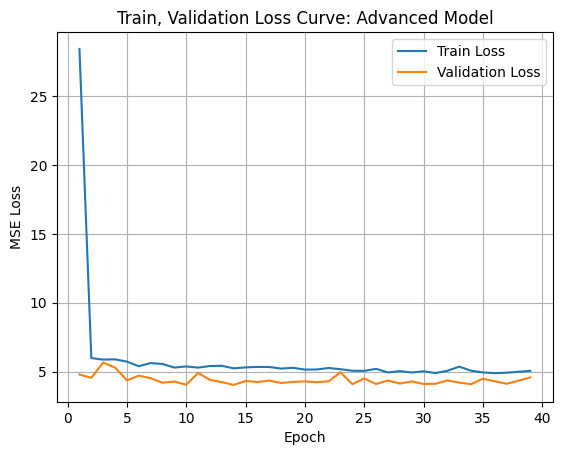

In [12]:
# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience, lambda_reg=1e-3)
plot_loss_curves(train_losses, val_losses, "Advanced Model")

The model predicts the age of abalone with an average error of about 2 rings.
The low validation MSE and RMSE suggest that the model is performing well, with minimal overfitting as seen in the close alignment of training and validation loss curves.

Both models end up with similar final validation MSE/RMSE, so overall performance is about the same. However, the advanced model shows more stable training curves with fewer spikes, which suggests better training stability and potentially better generalization if scaled up or tuned further.

### [Inference](#inference)

In [13]:
# Load the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
# Set the model to evaluation mode
model.eval()

predictions = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for features in test_loader: 
        features = features.to(device)
        outputs = model(features)
        
        # Outputs are floats, we can round the predictions to the nearest integer (Rings)
        if ROUND_PRED_TO_INTEGER:
            predictions.extend(torch.round(outputs.squeeze()).int().tolist())
        else:
            predictions.extend(outputs.squeeze().tolist())
        
# Save predictions (Rings) to a new CSV file with test data
output_df = pd.read_csv("data/test.csv")
output_df['Rings'] = predictions
output_df.to_csv(f"test{"_int" if ROUND_PRED_TO_INTEGER else ""}.csv", index=False)